# MLND 3d prototype 1 version 1

This notebook contains Python code and relevant equations to produce a 3d kernel space warp.  It concludes with a 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact
from ipywidgets import widgets
%matplotlib inline

The next cell generates a random circle dataset - so if you don't like the look of the distribution or the number points given in 'circle_data.csv' you can generate a new one.

In any case - we start with an image of this type of 2 dimensional circular dataset.

In [33]:
def make_dataset(num_pts):
    '''
    This function generates a random circle dataset with two classes. 
    You can run this a couple times to get a distribution you like visually.  
    You can also adjust the num_pts parameter to change the total number of points in the dataset.
    '''

    # generate points
    num_pts = 100
    a = np.random.rand(num_pts)
    x = np.cos(2*np.pi*a)
    y = np.sin(2*np.pi*a)
    radi = 2*np.random.rand(num_pts)
    x = x*radi
    y = y*radi

    # make labels
    labels = radi.copy()
    pos_inds = np.argwhere(radi < 1)
    pos_inds = [s[0] for s in pos_inds]

    neg_inds = np.argwhere(radi >=1)
    neg_inds = [s[0] for s in neg_inds]

    labels[pos_inds] = +1
    labels[neg_inds] = -1

    # produce figure
    fig = plt.figure(figsize = (4,4))
    ax = fig.add_subplot(111)
    ax.scatter(x[pos_inds],y[pos_inds],color = 'b',linewidth = 1)
    ax.scatter(x[neg_inds],y[neg_inds],color = 'y',linewidth = 1)

    # clean up plot
    ax.set_yticks([],[])
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    ax.axis('off') 

    # save dataset as csv
    x = np.asarray(x)
    x.shape = (len(x),1)
    y.shape = (len(y),1)
    labels = np.asarray(labels)
    labels.shape = (len(labels),1)
    dataset = np.concatenate( (x,y),axis = 1)
    all_data = np.concatenate((dataset,labels),axis = 1)
    all_data = pd.DataFrame(all_data)
    all_data.columns = ['x-coordinate','y-coordinate','label']
    all_data.to_csv('circle_data.csv',index = False)
    
    # return datapoints and labels for further 
    return all_data

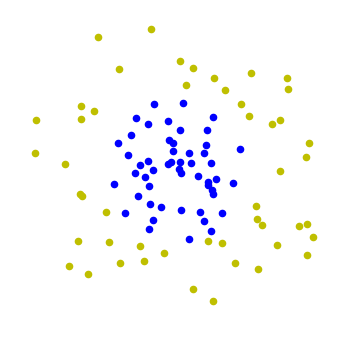

In [35]:
# use the function above to generate some random circle data with two classes = colors
all_data = make_dataset(num_pts = 100)

The next cell contains a function illustrating the main part of the animation desired.  Here we view the points from an angle in 3 dimensions.  This transition - from 2 to 3 dimensions - should be animated.

As you slide from left to right the space is warped upwards until the two types of points - yellow and blue - can be completely separated by a plane.  Lets check it out.

In [23]:
# a general purpose function for running and plotting the result of a user-defined input classification algorithm
def kernel_warp():
    # load in dataset
    dataset = np.asarray(pd.read_csv('circle_data.csv'))
    x = dataset[:,0]
    y = dataset[:,1]
    labels = dataset[:,2]
    pos_inds = np.argwhere(labels < 1)
    pos_inds = [s[0] for s in pos_inds]

    neg_inds = np.argwhere(labels >=1)
    neg_inds = [s[0] for s in neg_inds]

    # setup surface points
    X = np.arange(-3, 3, 0.25)
    Y = np.arange(-3, 3, 0.25)
    X, Y = np.meshgrid(X, Y)
    Z1 = np.zeros((np.shape(X)))
    Z2 = X*X + Y*Y - 1
    
    # generate circle
    theta = np.linspace(0,1,100)
    s = np.cos(2*np.pi*theta)
    t = np.sin(2*np.pi*theta)
    
    # transition through warp using slider toy
    def show_fit(alpha):
        # setup figure
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        plt.hold(True)

        # make new surface to plot
        beta = float(alpha)/float(alpha+10) # This slider widget only accepts integer step values >=1, so beta is expressed as an integer valued alpha - no worries, when alpha is zero so is beta, and when shoved to its maximum value beta is very close to one
        Z1 = np.zeros((np.shape(X)))
        Z3 = Z1 + beta*Z2
        ax.plot_surface(X, Y, Z3, rstride=1, cstride=1,alpha = 0.05)

        # plot pts
        z = np.zeros((len(pos_inds),1))
        x1 = x[pos_inds]
        y1 = y[pos_inds]
        z1 = beta*(x1*x1 + y1*y1 - 1)  # lift up the points with the surface
        ax.scatter(x1,y1,z1,color = 'b',linewidth = 1)

        x1 = x[neg_inds]
        y1 = y[neg_inds]
        z1 = beta*(x1*x1 + y1*y1 - 1)  # lift up the points with the surface
        ax.scatter(x1,y1,z1,color = 'y',linewidth = 1)

        # if we reach near the end of the slider slice the points with proper z-plane
        if alpha > 95:
            Z1 = np.zeros((np.shape(X)))
            ax.plot_surface(X, Y, Z1, rstride=1, cstride=1,alpha = 0.05,color = 'r')
        
        # if we reach the end of the slider show the circle
        if alpha == 100:
            ax.plot(s,t,np.zeros((np.shape(s))),'k')
        
        # clean up plot
        ax.view_init(5, 30)
        ax.set_xlim([-2,2])
        ax.set_ylim([-2,2])
        ax.set_zlim([-2,5])
        ax.axis('off');
    interact(show_fit, alpha=widgets.IntSlider(min=0,max=100,step=1,value=0))

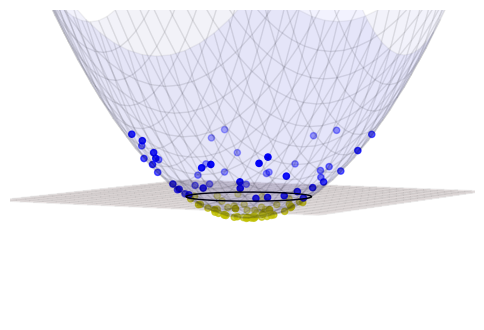

In [24]:
# run the kernel_warp function above
kernel_warp()

We are looking to animate the process of the slider moving from all the way left to all the way right above, to showcase this warping.

The math behind this warp.

We're in 3 dimensions - so we have an $X$,$Y$, and $Z$ coordinate for each point.

At first all of the points lie on the plane $Z_1 = 0.$

The final curved up surface - that separates the points completely - has the equation $Z_2 = X^2 + Y^2 - 1$, a parabola.

To transition smoothly from the plane to the surface the function above plots

$Z_3 = Z_1 + \beta*Z_2$

where $\beta$ is between 0 and 1.  As you move the slider from left to right above $\beta$ goes from $0$ (all the way left) to $1$ (all the way right).  All of the points need to be shoved through $Z3$ as well for them to travel along with the surface.  You can see these transformations in the function **kernel_warp** above. 

Note: you can ignore the 'alpha' value printed out by the slider.  Look in the function itself to see how this 'alpha' value leads to a value of 'beta' between 0 and 1.

When the slider reaches the right side a red plane is shown that separates the blue from yellow points in 3 dimensions.  This red plane has the equation.

$Z = 1$.

This red plane is shown for the last few values of the slider - but should only be shown in the animation when $\beta = 1$W.

After this animation finishes, we would like the following final image to be shown.  We go back to 2 dimensions, looking at the points from above.  We now add the intersection between the blue parabolic surface and the red cutting plane to this picture - which is just a circle in two dimensions.  This circle has the equation

$X^2 + Y^2 = 1$

Ideally we would have a smooth animation from the final setting on the slider - in 3 dimensions - to this image below in two dimensions.  Notice how this circle is highlighted in the 3 dimensional image when the slider is pushed all the way to the right.

In [25]:
# function for plotting the data with circular separator
def plot_data_and_separator():
    # load in dataset
    dataset = np.asarray(pd.read_csv('circle_data.csv'))
    x = dataset[:,0]
    y = dataset[:,1]
    labels = dataset[:,2]
    pos_inds = np.argwhere(labels < 1)
    pos_inds = [s[0] for s in pos_inds]

    neg_inds = np.argwhere(labels >=1)
    neg_inds = [s[0] for s in neg_inds]
    
    # produce figure
    fig = plt.figure(figsize = (4,4))
    ax = fig.add_subplot(111)
    
    # plot points
    ax.scatter(x[pos_inds],y[pos_inds],color = 'b',linewidth = 1)
    ax.scatter(x[neg_inds],y[neg_inds],color = 'y',linewidth = 1)

    # plot circle
    theta = np.linspace(0,1,100)
    s = np.cos(2*np.pi*theta)
    t = np.sin(2*np.pi*theta)
    ax.plot(s,t,'k')
    
    # clean up plot
    ax.set_yticks([],[])
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    ax.axis('off') 

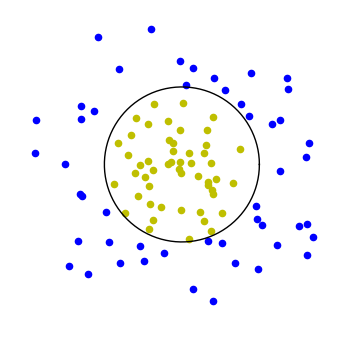

In [18]:
plot_data_and_separator()